# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import json

from sklearn.feature_selection import mutual_info_classif

from collections import defaultdict

from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/03c_features_analysis'

# Loading data

In [4]:
path_to_ftir_data= './../data/processed_data/ftir_features_long_list.csv'
path_to_features_description = './../data/processed_data/features_description.json'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-features (*long-list*)

In [5]:
features_df = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(features_df.shape)
features_df.head(3)

(75, 484)


$\overline{I}_{3800\text{–}2500}$  $I_{3371}$  \
division_1_size_bulk                           0.526201    0.986316   
division_1_size_5                              0.477909    1.000000   
division_1_size_3                              0.535789    1.000000   

                      $\overline{I}_{3371 \pm 32}$  $I_{3290}$  \
division_1_size_bulk                      0.979846    0.963846   
division_1_size_5                         0.994511    0.921248   
division_1_size_3                         0.987733    0.934053   

                      $\overline{I}_{3290 \pm 32}$  $I_{2928}$  \
division_1_size_bulk                      0.960911    0.491720   
division_1_size_5                         0.919686    0.406937   
division_1_size_3                         0.932223    0.618445   

                      $\overline{I}_{2928 \pm 32}$  \
division_1_size_bulk                      0.492079   
division_1_size_5                         0.401135   
division_1_size_3                         0.598930   

                      $\overline{I}_{1800\text{–}900}$  \
division_1_size_bulk                          0.504366   
division_1_size_5                             0.451487   
division_1_size_3                             0.517003   

                      $\overline{I}_{1800\text{–}1500}$  $I_{1722}$  \
division_1_size_bulk                           0.537705    0.426530   
division_1_size_5                              0.497036    0.387542   
division_1_size_3                              0.549005    0.375077   

                      $\overline{I}_{1722 \pm 32}$  $I_{1640}$  \
division_1_size_bulk                      0.422144         1.0   
division_1_size_5                         0.383206         1.0   
division_1_size_3                         0.381174         1.0   

                      $\overline{I}_{1640 \pm 32}$  $I_{1596}$  \
division_1_size_bulk                      0.881929    0.859947   
division_1_size_5                         0.881966    0.838260   
division_1_size_3                         0.897655    0.893725   

                      $\overline{I}_{1596 \pm 32}$  $I_{1541}$  \
division_1_size_bulk                      0.831074    0.367672   
division_1_size_5                         0.805705    0.297496   
division_1_size_3                         0.871536    0.461156   

                      $\overline{I}_{1541 \pm 32}$  \
division_1_size_bulk                      0.398300   
division_1_size_5                         0.331232   
division_1_size_3                         0.484095   

                      $\overline{I}_{1500\text{–}1300}$  $I_{1391}$  \
division_1_size_bulk                           0.571735    0.760582   
division_1_size_5                              0.502368    0.687458   
division_1_size_3                              0.523513    0.696553   

                      $\overline{I}_{1391 \pm 32}$  \
division_1_size_bulk                      0.729089   
division_1_size_5                         0.657981   
division_1_size_3                         0.667164   

                      $\overline{I}_{1300\text{–}900}$  $I_{1240}$  \
division_1_size_bulk                          0.445780    0.452765   
division_1_size_5                             0.391974    0.426756   
division_1_size_3                             0.489773    0.400246   

                      $\overline{I}_{1240 \pm 32}$  $I_{1181}$  \
division_1_size_bulk                      0.443662    0.390690   
division_1_size_5                         0.423141    0.418615   
division_1_size_3                         0.402681    0.519599   

                      $\overline{I}_{1181 \pm 32}$  ...  \
division_1_size_bulk                      0.407574  ...   
division_1_size_5                         0.432865  ...   
division_1_size_3                         0.536948  ...   

                      $\frac{I_{1067}}{\overline{I}_{873 \pm 32}}$  \
division_1_size_bulk                                     14.315529   
division_1_size_5                  

## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


Row_ID  Division  Size Fraction_hue  \
division_1_size_bulk       1         1  bulk        $> 0$   
division_1_size_5          2         1     5        $< 5$   
division_1_size_3          3         1     3        $< 3$   

                     Fraction_grouped_hue  Class  
division_1_size_bulk              $d > 5$      2  
division_1_size_5          $2 < d \leq 5$      1  
division_1_size_3          $2 < d \leq 5$      1

# Data wrangling

## Base parameters

In [8]:
hue = samples_description['Fraction_grouped_hue'].tolist()
hue_order = sorted(set(hue))

target = samples_description['Class'].tolist()

In [9]:
type_color_dict = {
    '$0< d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [10]:
groups = list(type_color_dict.keys())

In [11]:
feature_types = [
    'base_features_peaks_3800_2500',
    'base_features_intervals_3800_2500',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800',
    'engineered_features_peaks_3800_2500',
    'engineered_features_intervals_3800_2500',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

In [12]:
sns.set_theme()

# Features analysis

## Mutual information

In [13]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 18,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 16,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 16,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 7
}

TITLE_MAP = {
    'peaks_3800_2500': 'Точечные | 3800–2500 см$^{-1}$',
    'intervals_3800_2500': 'Интегральные | 3800–2500 см$^{-1}$',
    'peaks_1900_800': 'Точечные | 1900–800 см$^{-1}$',
    'intervals_1900_800': 'Интегральные | 1900–800 см$^{-1}$'
}

COLORS = {
    'base': 'RoyalBlue',
    'engineered': 'SeaGreen'
}

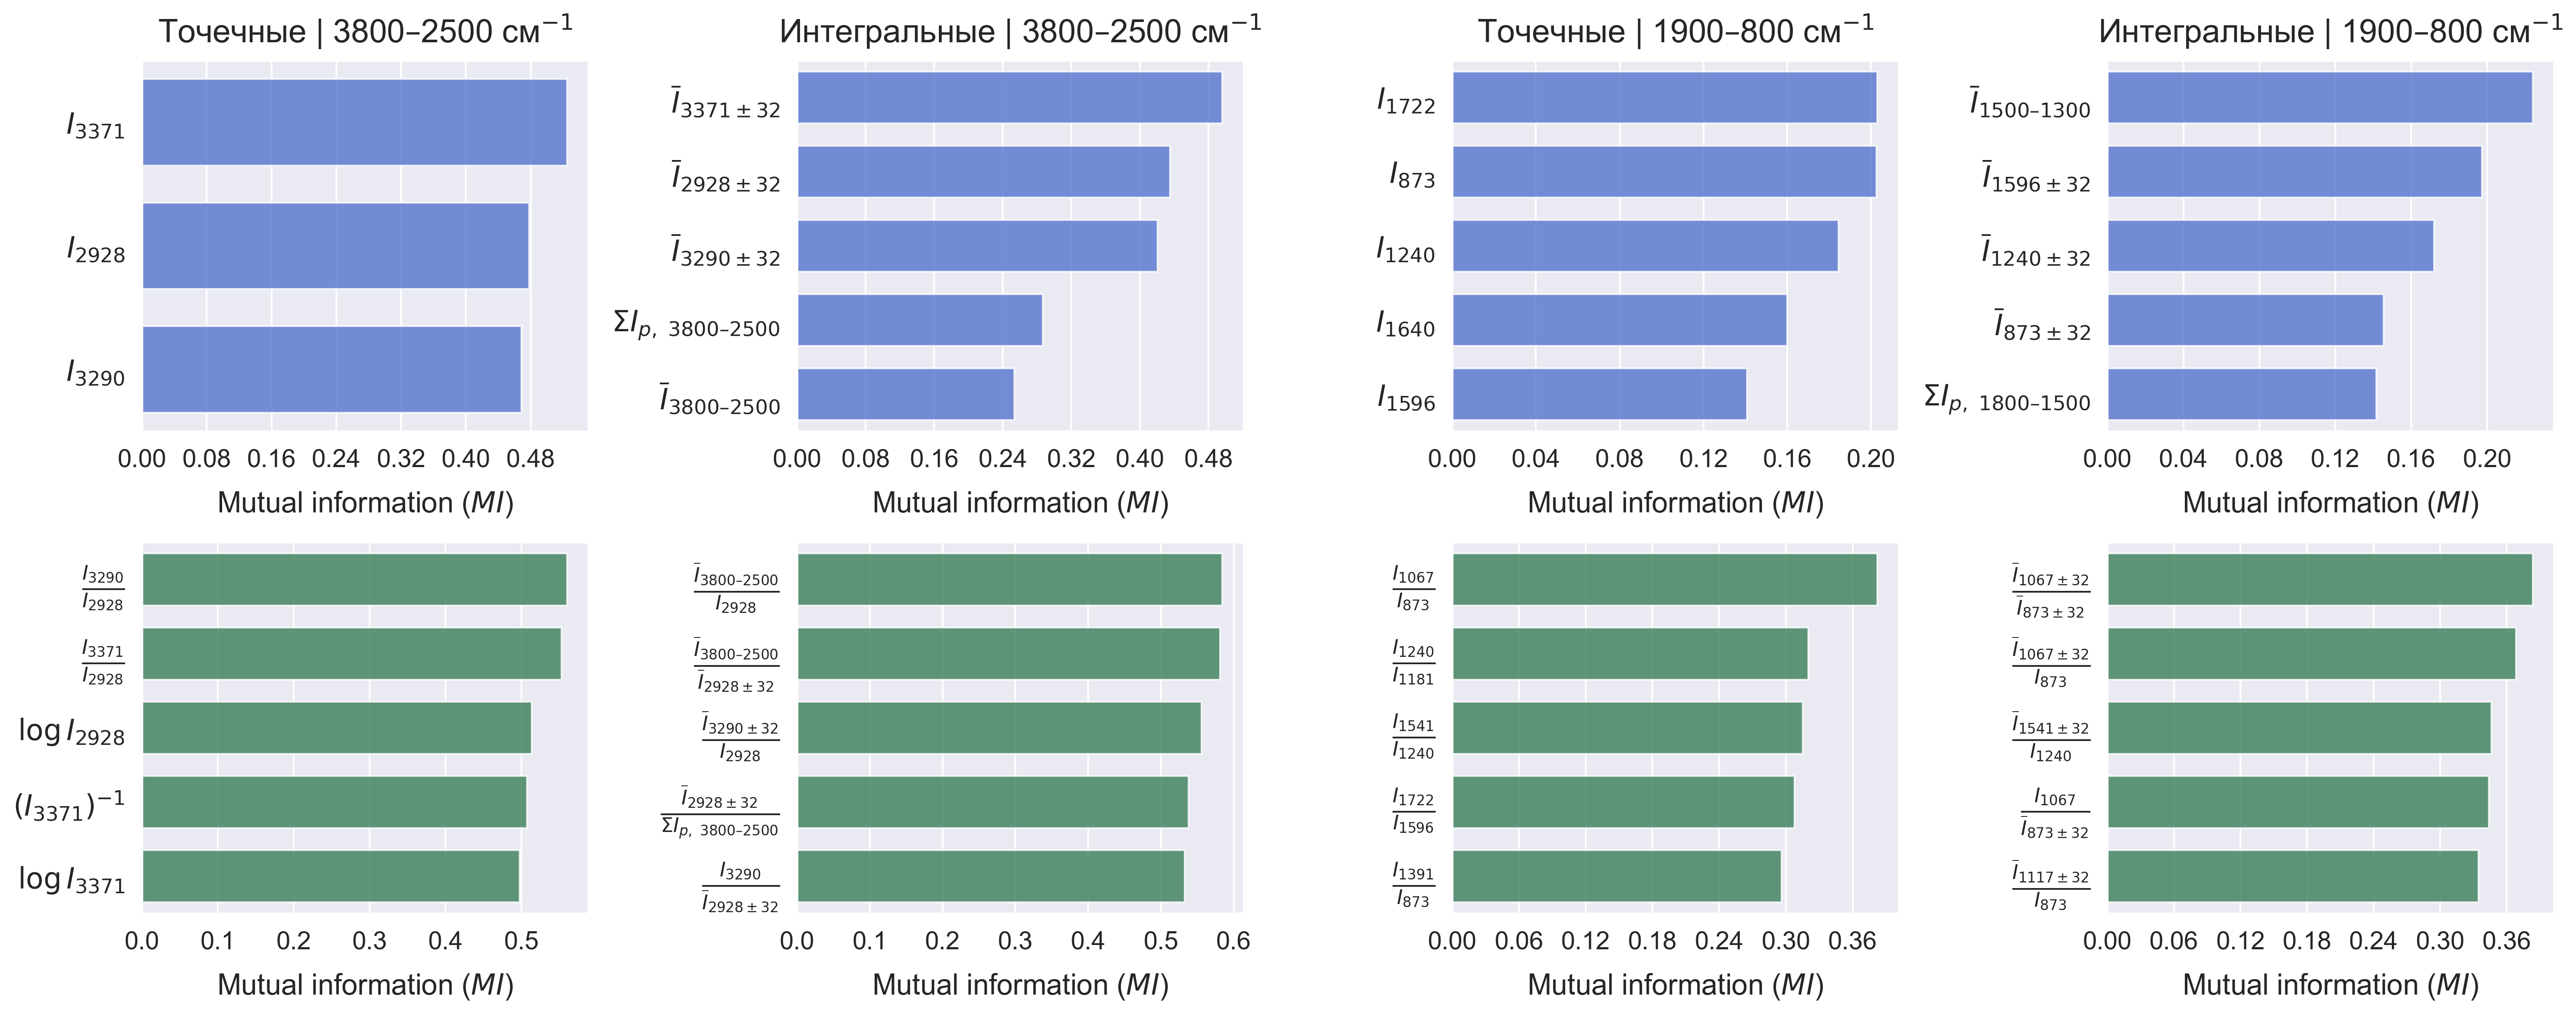

In [14]:
nrows = 2
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4), dpi=300)
axes = axes.flat

for i, feature_type in enumerate(feature_types):
    X_subset = features_df[features_description[feature_type]]
    y_subset = target

    mi = mutual_info_classif(X_subset, y_subset, discrete_features='auto', random_state=42)
    
    result_df = pd.DataFrame({
        'Feature': X_subset.columns,
        'Mutual_Info': mi
    })
    result_df = result_df.sort_values(by='Mutual_Info', ascending=False).head(5)

    ax = axes[i]
    
    kind = 'engineered' if 'engineered' in feature_type else 'base'
    plot_color = COLORS[kind]

    sns.barplot(
        data=result_df,
        x='Mutual_Info',
        y='Feature',
        ax=ax,
        color=plot_color,
        width=0.7,
        alpha=0.8
    )

    if i < 4:
        key = '_'.join(feature_type.split('_')[2:])
        ax.set_title(TITLE_MAP[key], fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'], pad=10)
        ax.set_xlabel('')
    
    ax.set_xlabel('Mutual information ($MI$)', fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])

    ax.set_ylabel('', fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/mutual_info_barplots.png', dpi=600)

plt.show()

## Visualization (BoxPlot & ViolinPlot)

In [15]:
base_feature_types = [
    'base_features_peaks_3800_2500',
    'base_features_intervals_3800_2500',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800'
]

engineered_feature_types = [
    'engineered_features_peaks_3800_2500',
    'engineered_features_intervals_3800_2500',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

### Function for sorting by *MS*

In [16]:
def get_ranked_features_by_mutual_info(features_df, target, features_description, feature_types):
    results_lst = []
    
    for feature_type in feature_types:
        X = features_df[features_description[feature_type]]
        mi = mutual_info_classif(X, target, discrete_features='auto', random_state=42)
        
        data = pd.DataFrame({
            'Feature': X.columns,
            'Mutual_Info': mi,
            'Feature_Type': feature_type
        })
        data = data.sort_values('Mutual_Info', ascending=False).reset_index(drop=True)
        
        results_lst.append(data)

    result_data = pd.concat(results_lst, ignore_index=True)
    return result_data

### *Base* features

#### Ranking features

In [17]:
ranked_data = get_ranked_features_by_mutual_info(
    features_df=features_df,
    target=target,
    features_description=features_description,
    feature_types=base_feature_types
)

print(ranked_data.shape)
ranked_data.head(3)

(36, 3)


Feature  Mutual_Info                   Feature_Type
0  $I_{3371}$     0.524850  base_features_peaks_3800_2500
1  $I_{2928}$     0.478013  base_features_peaks_3800_2500
2  $I_{3290}$     0.468650  base_features_peaks_3800_2500

In [18]:
top_n = 3

top_features_df = ranked_data.groupby('Feature_Type').head(top_n)

print(top_features_df.shape)
top_features_df.head(3)

(12, 3)


Feature  Mutual_Info                   Feature_Type
0  $I_{3371}$     0.524850  base_features_peaks_3800_2500
1  $I_{2928}$     0.478013  base_features_peaks_3800_2500
2  $I_{3290}$     0.468650  base_features_peaks_3800_2500

In [19]:
top_features = top_features_df['Feature']

#### Data preparation

In [20]:
df_vis = features_df[top_features].copy()
df_vis['target'] = target
df_vis['hue'] = hue

print(df_vis.shape)
df_vis.head(3)

(75, 14)


$I_{3371}$  $I_{2928}$  $I_{3290}$  \
division_1_size_bulk    0.986316    0.491720    0.963846   
division_1_size_5       1.000000    0.406937    0.921248   
division_1_size_3       1.000000    0.618445    0.934053   

                      $\overline{I}_{3371 \pm 32}$  \
division_1_size_bulk                      0.979846   
division_1_size_5                         0.994511   
division_1_size_3                         0.987733   

                      $\overline{I}_{2928 \pm 32}$  \
division_1_size_bulk                      0.492079   
division_1_size_5                         0.401135   
division_1_size_3                         0.598930   

                      $\overline{I}_{3290 \pm 32}$  $I_{1722}$  $I_{873}$  \
division_1_size_bulk                      0.960911    0.426530   0.048208   
division_1_size_5                         0.919686    0.387542   0.091875   
division_1_size_3                         0.932223    0.375077   0.110321   

                      $I_{1240}$  $\overline{I}_{1500\text{–}1300}$  \
division_1_size_bulk    0.452765                           0.571735   
division_1_size_5       0.426756                           0.502368   
division_1_size_3       0.400246                           0.523513   

                      $\overline{I}_{1596 \pm 32}$  \
division_1_size_bulk                      0.831074   
division_1_size_5                         0.805705   
division_1_size_3                         0.871536   

                      $\overline{I}_{1240 \pm 32}$  target             hue  
division_1_size_bulk                      0.443662       2         $d > 5$  
division_1_size_5                         0.423141       1  $2 < d \leq 5$  
division_1_size_3                         0.402681       1  $2 < d \leq 5$

In [21]:
feature_type_by_feature = dict(zip(ranked_data['Feature'], ranked_data['Feature_Type']))

grouped_features = defaultdict(list)

for feature in df_vis.columns:
    if feature in ['target', 'hue']:
        continue
    
    feature_type = feature_type_by_feature[feature]
    grouped_features[feature_type].append(feature)

#### Box plot

In [22]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'BOX_WIDTH': 0.6,
    'STRIP_ALPHA': 0.7,
    'STRIP_SIZE': 8,
    'STRIP_LINEWIDTH': 0.5,
    'STRIP_DODGE': True
}

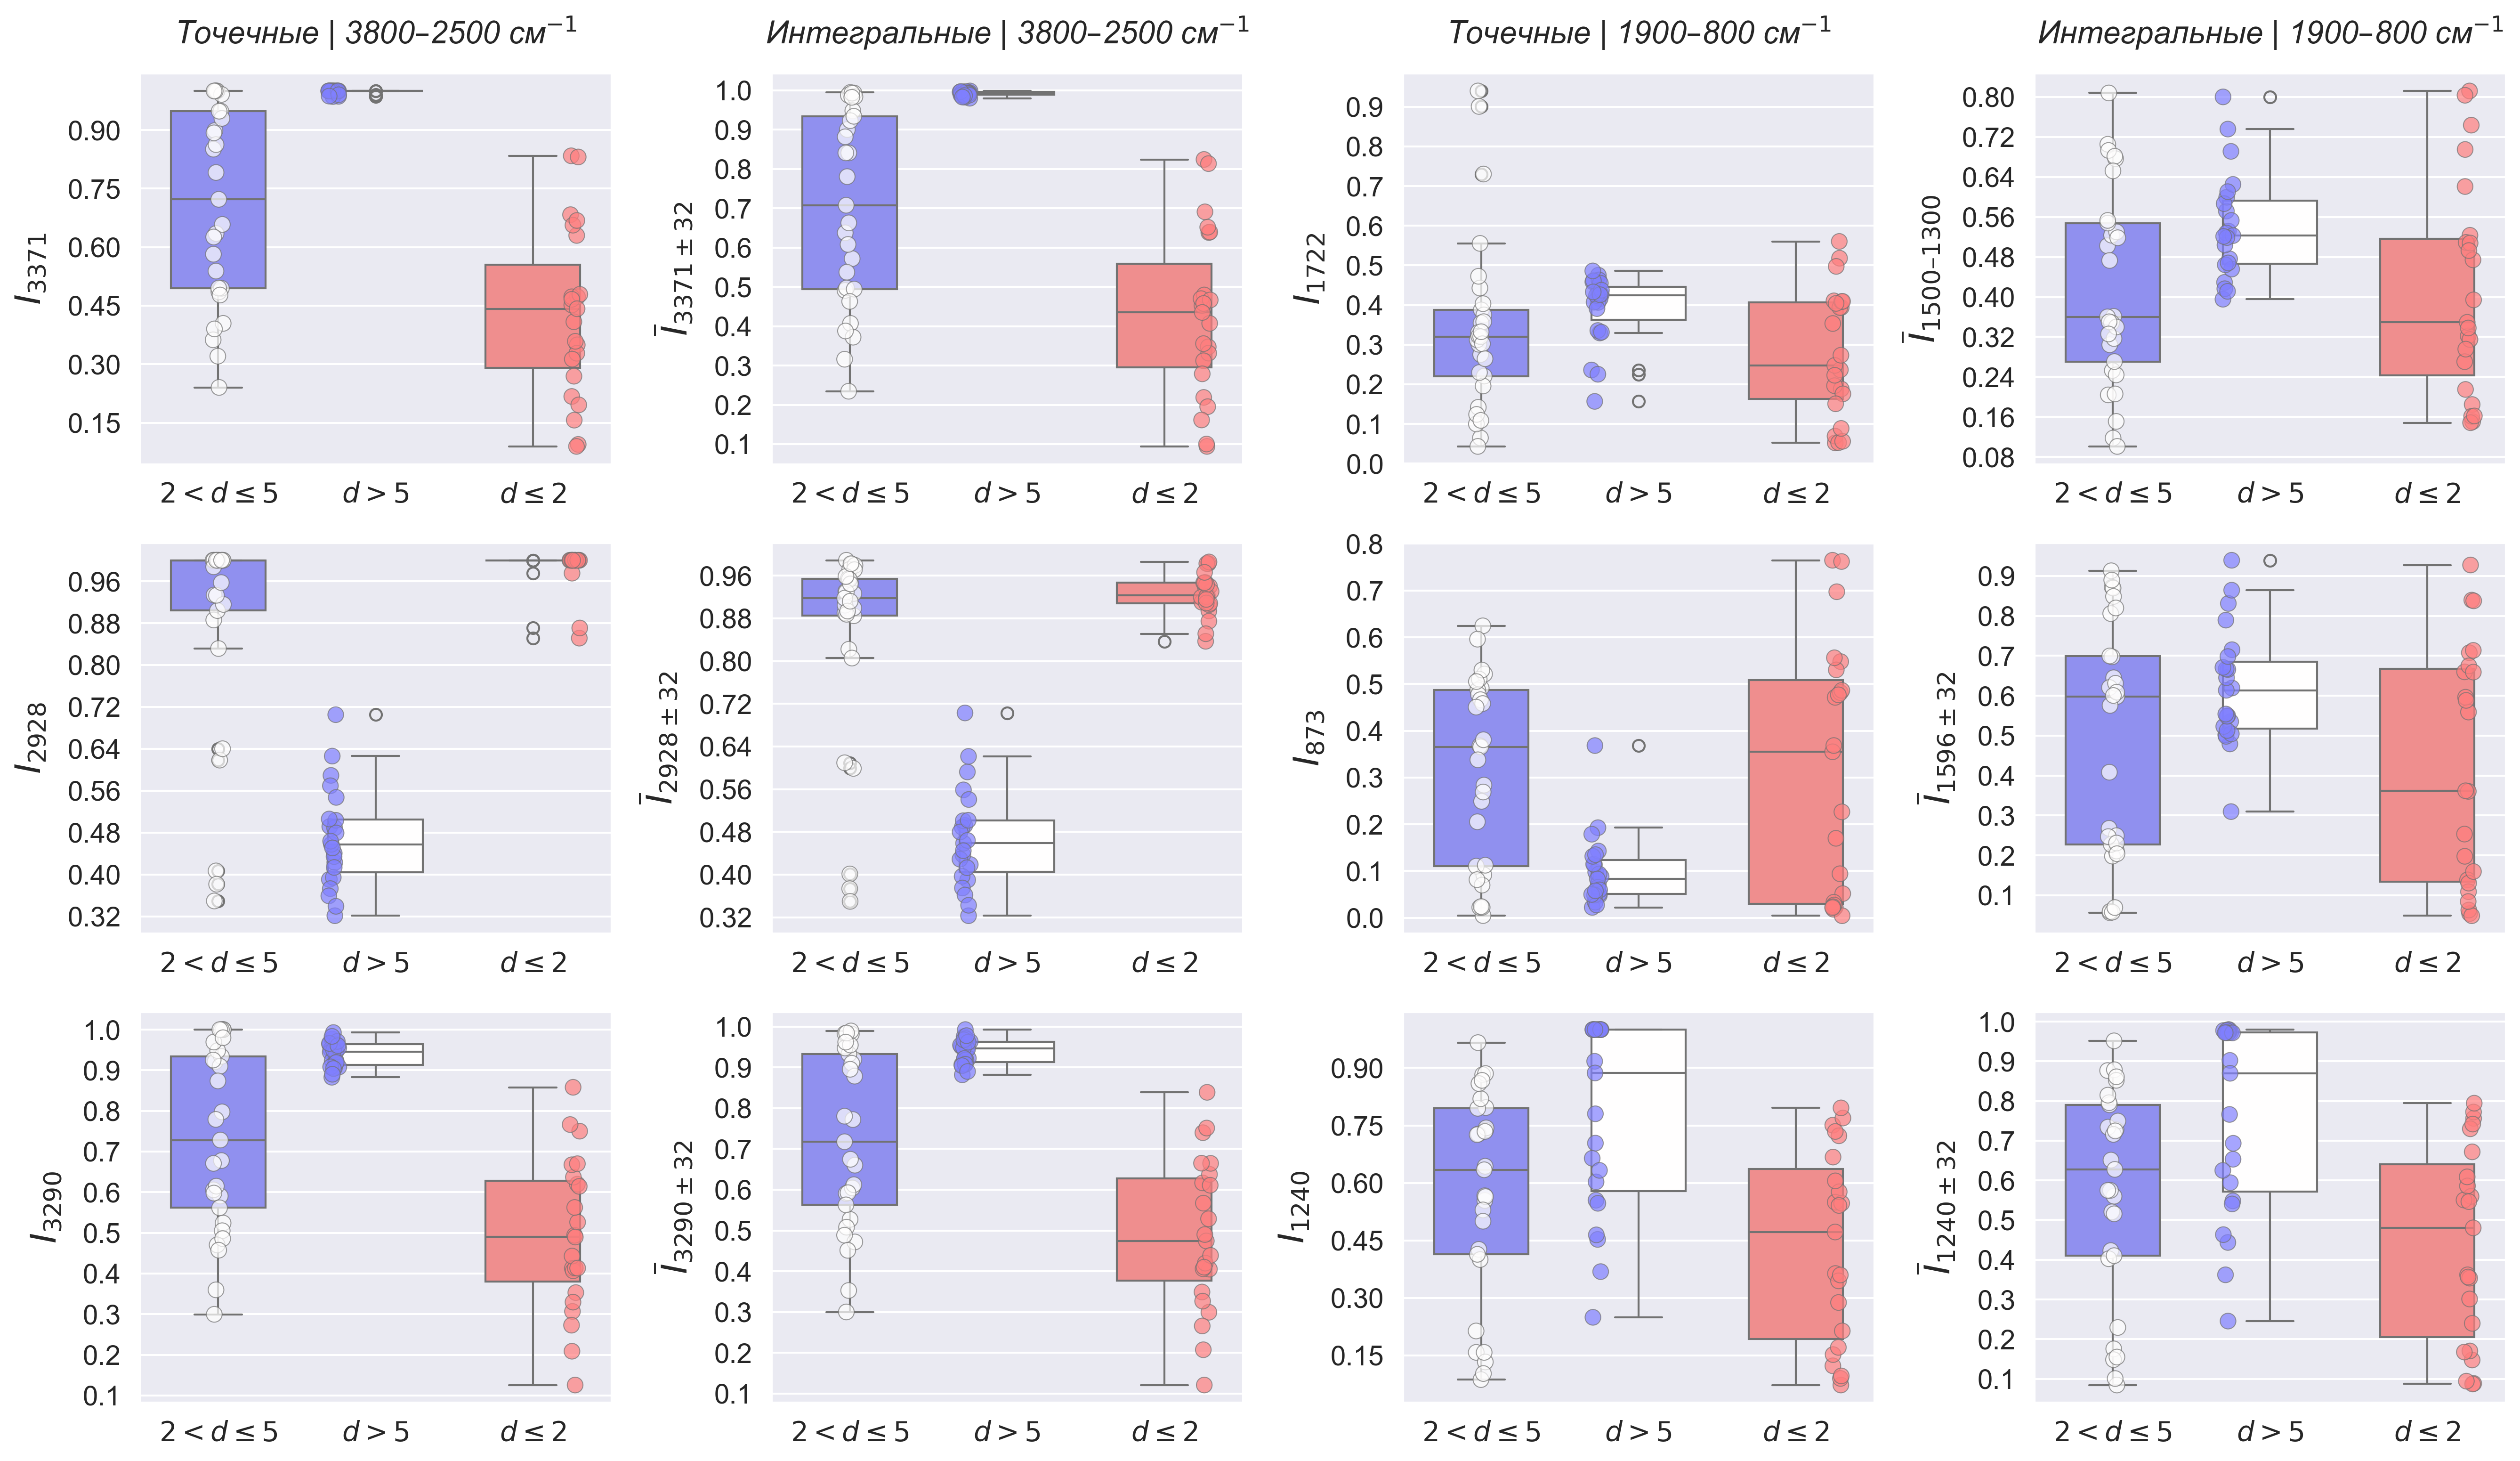

In [23]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.boxplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette='bwr',
            width=PLOT_STYLE['BOX_WIDTH'],
            order=hue_order,
            ax=ax
        )

        sns.stripplot(
            data=df_vis,
            x='hue',
            y=feature,
            hue='hue',
            palette='bwr',
            alpha=PLOT_STYLE['STRIP_ALPHA'],
            size=PLOT_STYLE['STRIP_SIZE'],
            linewidth=PLOT_STYLE['STRIP_LINEWIDTH'],
            dodge=PLOT_STYLE['STRIP_DODGE'],
            ax=ax,
            legend=False
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title, fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'], pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(feature, fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/boxplot_base_features.png', dpi=600)

plt.show()

#### Violin plot

In [24]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'VIOLIN_INNER': 'box',     # 'box', 'quartile', 'point', None
    'VIOLIN_CUT': 0,
    'VIOLIN_LINEWIDTH': 1,
    'PALETTE': 'bwr',
}


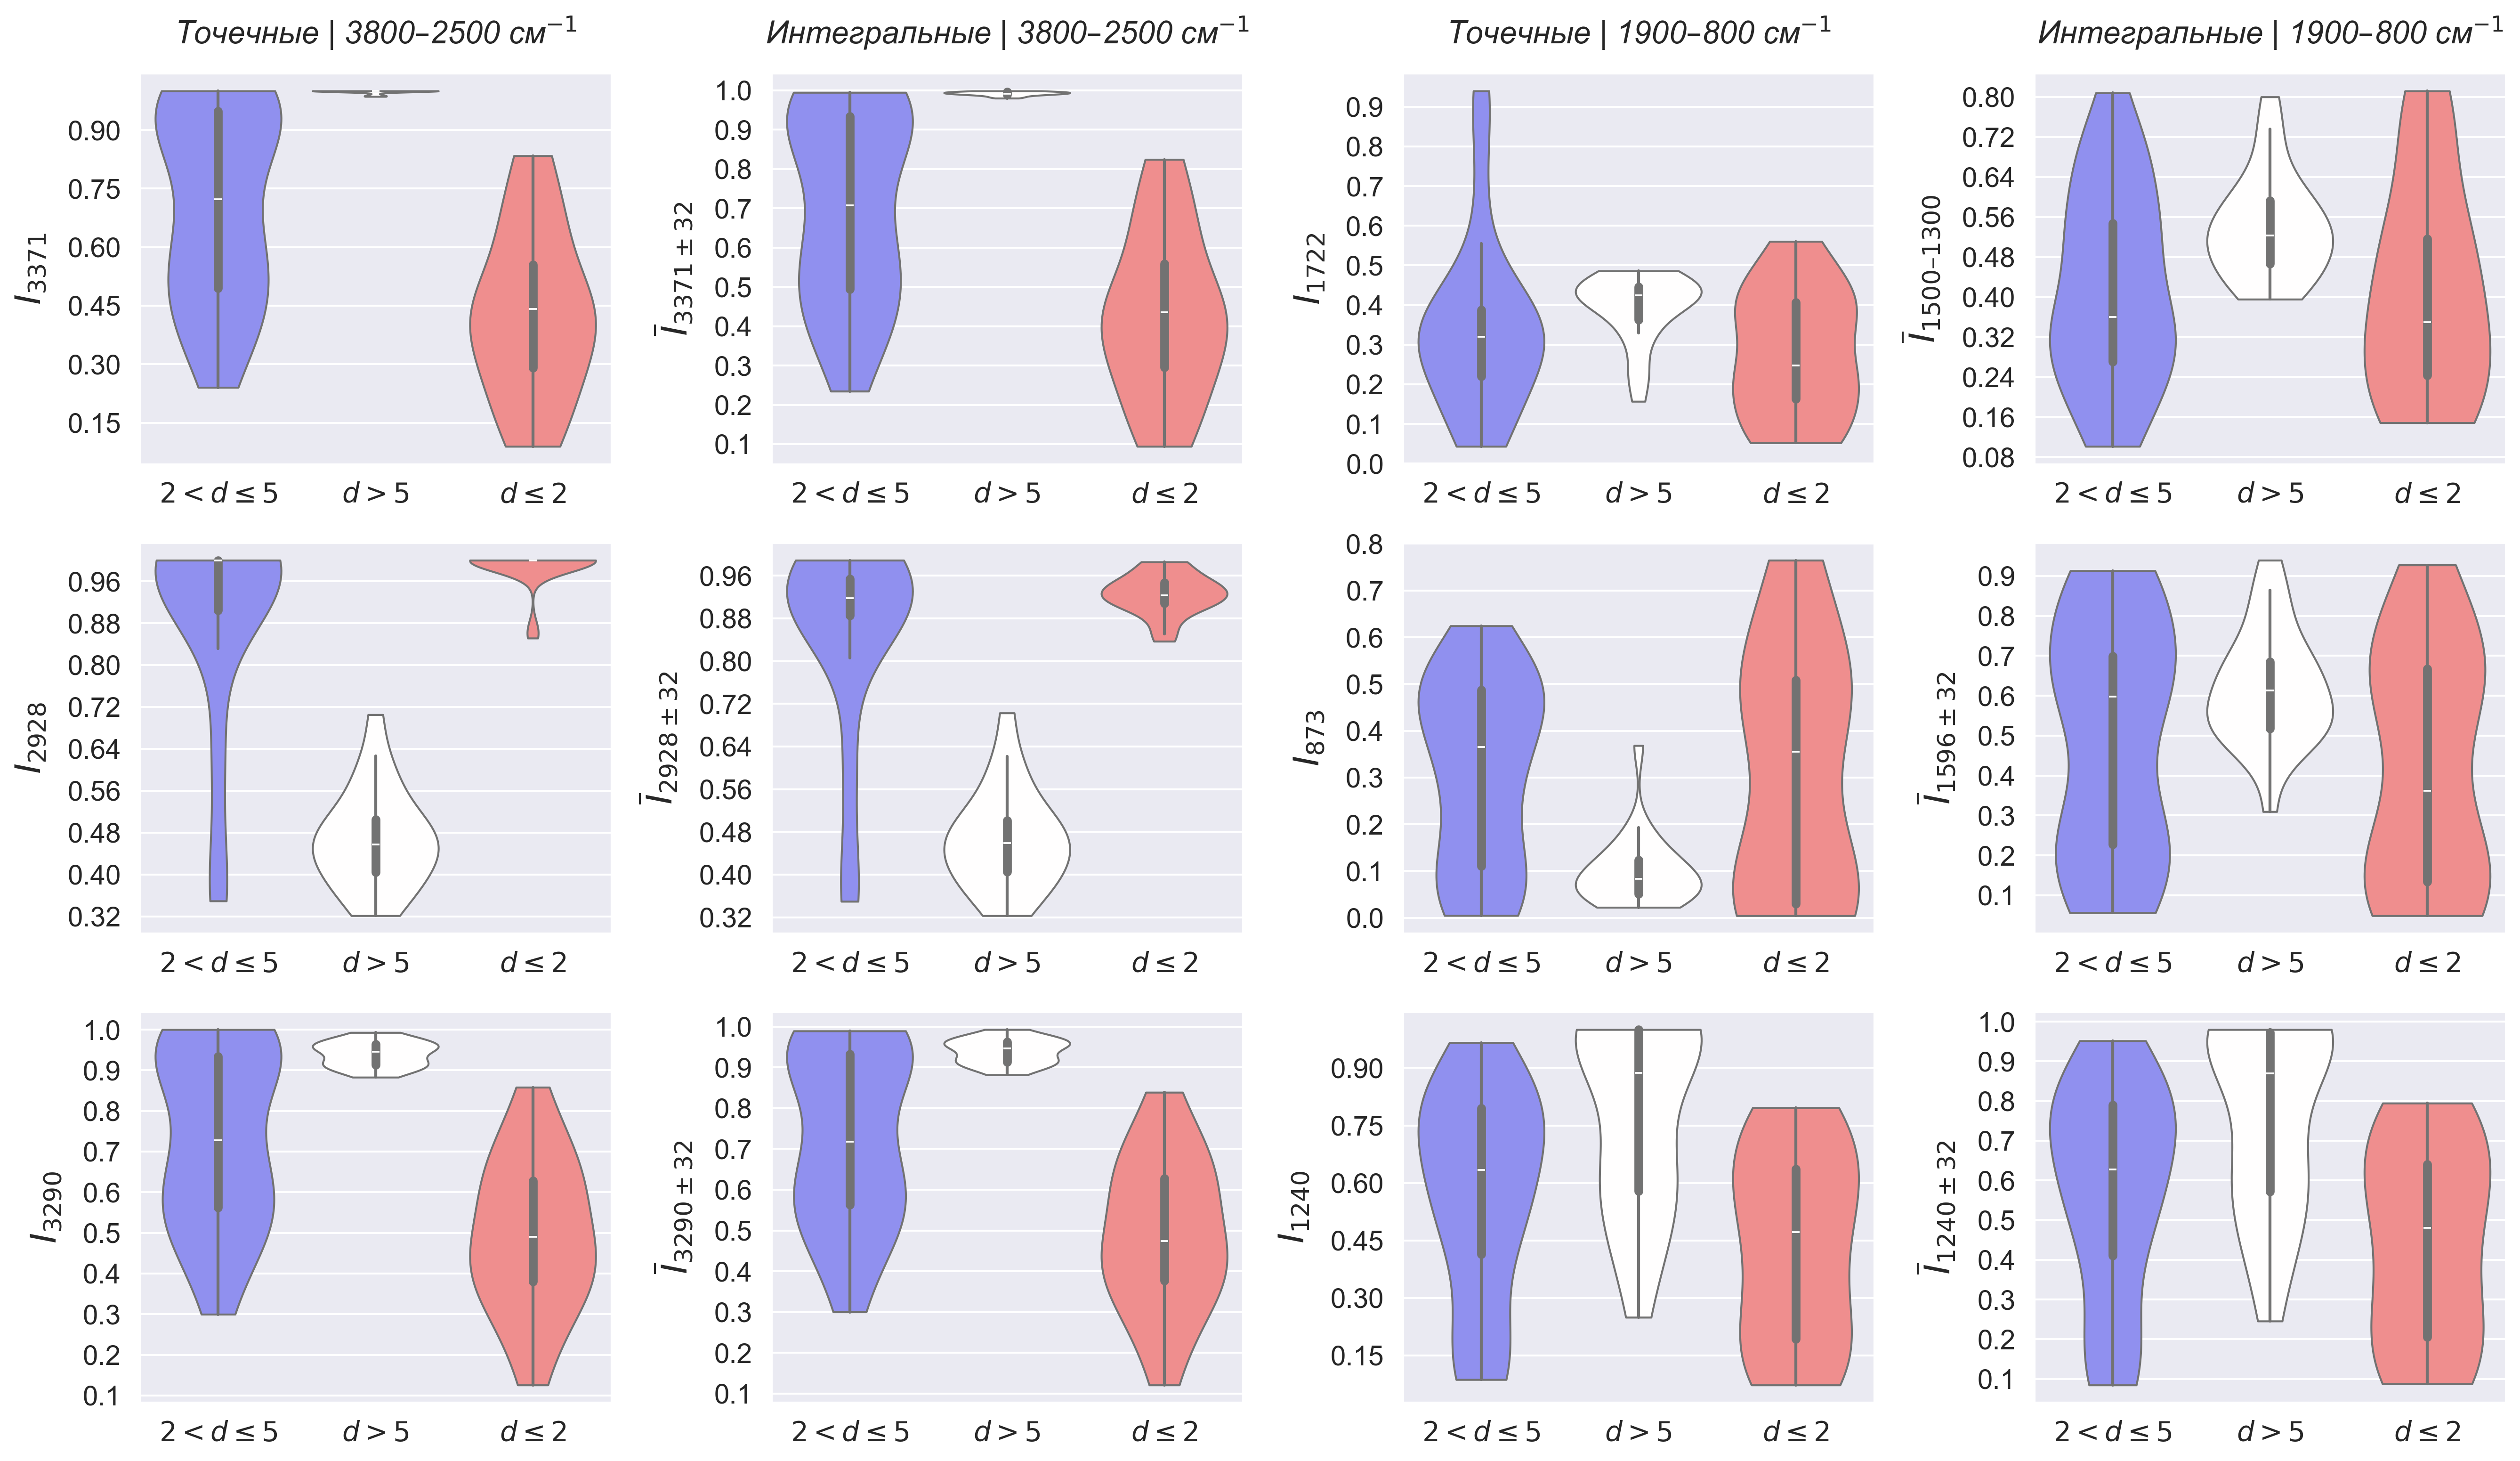

In [25]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.violinplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette=PLOT_STYLE['PALETTE'],
            cut=PLOT_STYLE['VIOLIN_CUT'],
            inner=PLOT_STYLE['VIOLIN_INNER'],
            linewidth=PLOT_STYLE['VIOLIN_LINEWIDTH'],
            order=hue_order,
            ax=ax
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title,
                         fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
                         fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
                         pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(
            feature,
            fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'],
            labelpad=PLOT_STYLE['Y_LABELPAD']
        )

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/violinplot_base_features.png', dpi=600)

plt.show()

### *Engineered* features

#### Ranking features

In [26]:
ranked_data = get_ranked_features_by_mutual_info(
    features_df=features_df,
    target=target,
    features_description=features_description,
    feature_types=engineered_feature_types
)

print(ranked_data.shape)
ranked_data.head(3)

(448, 3)


Feature  Mutual_Info  \
0  $\frac{I_{3290}}{I_{2928}}$     0.560365   
1  $\frac{I_{3371}}{I_{2928}}$     0.553000   
2              $\log I_{2928}$     0.513687   

                          Feature_Type  
0  engineered_features_peaks_3800_2500  
1  engineered_features_peaks_3800_2500  
2  engineered_features_peaks_3800_2500

In [27]:
top_n = 3

top_features_df = ranked_data.groupby('Feature_Type').head(top_n)

print(top_features_df.shape)
top_features_df.head(3)

(12, 3)


Feature  Mutual_Info  \
0  $\frac{I_{3290}}{I_{2928}}$     0.560365   
1  $\frac{I_{3371}}{I_{2928}}$     0.553000   
2              $\log I_{2928}$     0.513687   

                          Feature_Type  
0  engineered_features_peaks_3800_2500  
1  engineered_features_peaks_3800_2500  
2  engineered_features_peaks_3800_2500

In [28]:
top_features = top_features_df['Feature']

#### Data preparation

In [29]:
df_vis = features_df[top_features].copy()
df_vis['target'] = target
df_vis['hue'] = hue

print(df_vis.shape)
df_vis.head(3)

(75, 14)


$\frac{I_{3290}}{I_{2928}}$  \
division_1_size_bulk                     1.960155   
division_1_size_5                        2.263860   
division_1_size_3                        1.510325   

                      $\frac{I_{3371}}{I_{2928}}$  $\log I_{2928}$  \
division_1_size_bulk                     2.005851        -0.709847   
division_1_size_5                        2.457385        -0.899098   
division_1_size_3                        1.616959        -0.480547   

                      $\frac{\overline{I}_{3800\text{–}2500}}{I_{2928}}$  \
division_1_size_bulk                                            1.070125   
division_1_size_5                                               1.174407   
division_1_size_3                                               0.866349   

                      $\frac{\overline{I}_{3800\text{–}2500}}{\overline{I}_{2928 \pm 32}}$  \
division_1_size_bulk                                                              1.069344   
division_1_size_5                                                                 1.191391   
division_1_size_3                                                                 0.894577   

                      $\frac{\overline{I}_{3290 \pm 32}}{I_{2928}}$  \
division_1_size_bulk                                       1.954184   
division_1_size_5                                          2.260022   
division_1_size_3                                          1.507367   

                      $\frac{I_{1067}}{I_{873}}$  $\frac{I_{1240}}{I_{1181}}$  \
division_1_size_bulk                   14.132272                     1.158886   
division_1_size_5                       5.696843                     1.019448   
division_1_size_3                       6.433267                     0.770298   

                      $\frac{I_{1541}}{I_{1240}}$  \
division_1_size_bulk                     0.812060   
division_1_size_5                        0.697109   
division_1_size_3                        1.152181   

                      $\frac{\overline{I}_{1067 \pm 32}}{\overline{I}_{873 \pm 32}}$  \
division_1_size_bulk                                                       14.034424   
division_1_size_5                                                           5.484781   
division_1_size_3                                                           6.185033   

                      $\frac{\overline{I}_{1067 \pm 32}}{I_{873}}$  \
division_1_size_bulk                                     13.854766   
division_1_size_5                                         5.609242   
division_1_size_3                                         6.389564   

                      $\frac{\overline{I}_{1541 \pm 32}}{I_{1240}}$  target  \
division_1_size_bulk                                       0.879706       2   
division_1_size_5                                          0.776163       1   
division_1_size_3                                          1.209494       1   

                                 hue  
division_1_size_bulk         $d > 5$  
division_1_size_5     $2 < d \leq 5$  
division_1_size_3     $2 < d \leq 5$

In [30]:
feature_type_by_feature = dict(zip(ranked_data['Feature'], ranked_data['Feature_Type']))

grouped_features = defaultdict(list)

for feature in df_vis.columns:
    if feature in ['target', 'hue']:
        continue
    
    feature_type = feature_type_by_feature[feature]
    grouped_features[feature_type].append(feature)

#### Box plot

In [31]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'BOX_WIDTH': 0.6,
    'STRIP_ALPHA': 0.7,
    'STRIP_SIZE': 8,
    'STRIP_LINEWIDTH': 0.5,
    'STRIP_DODGE': True
}

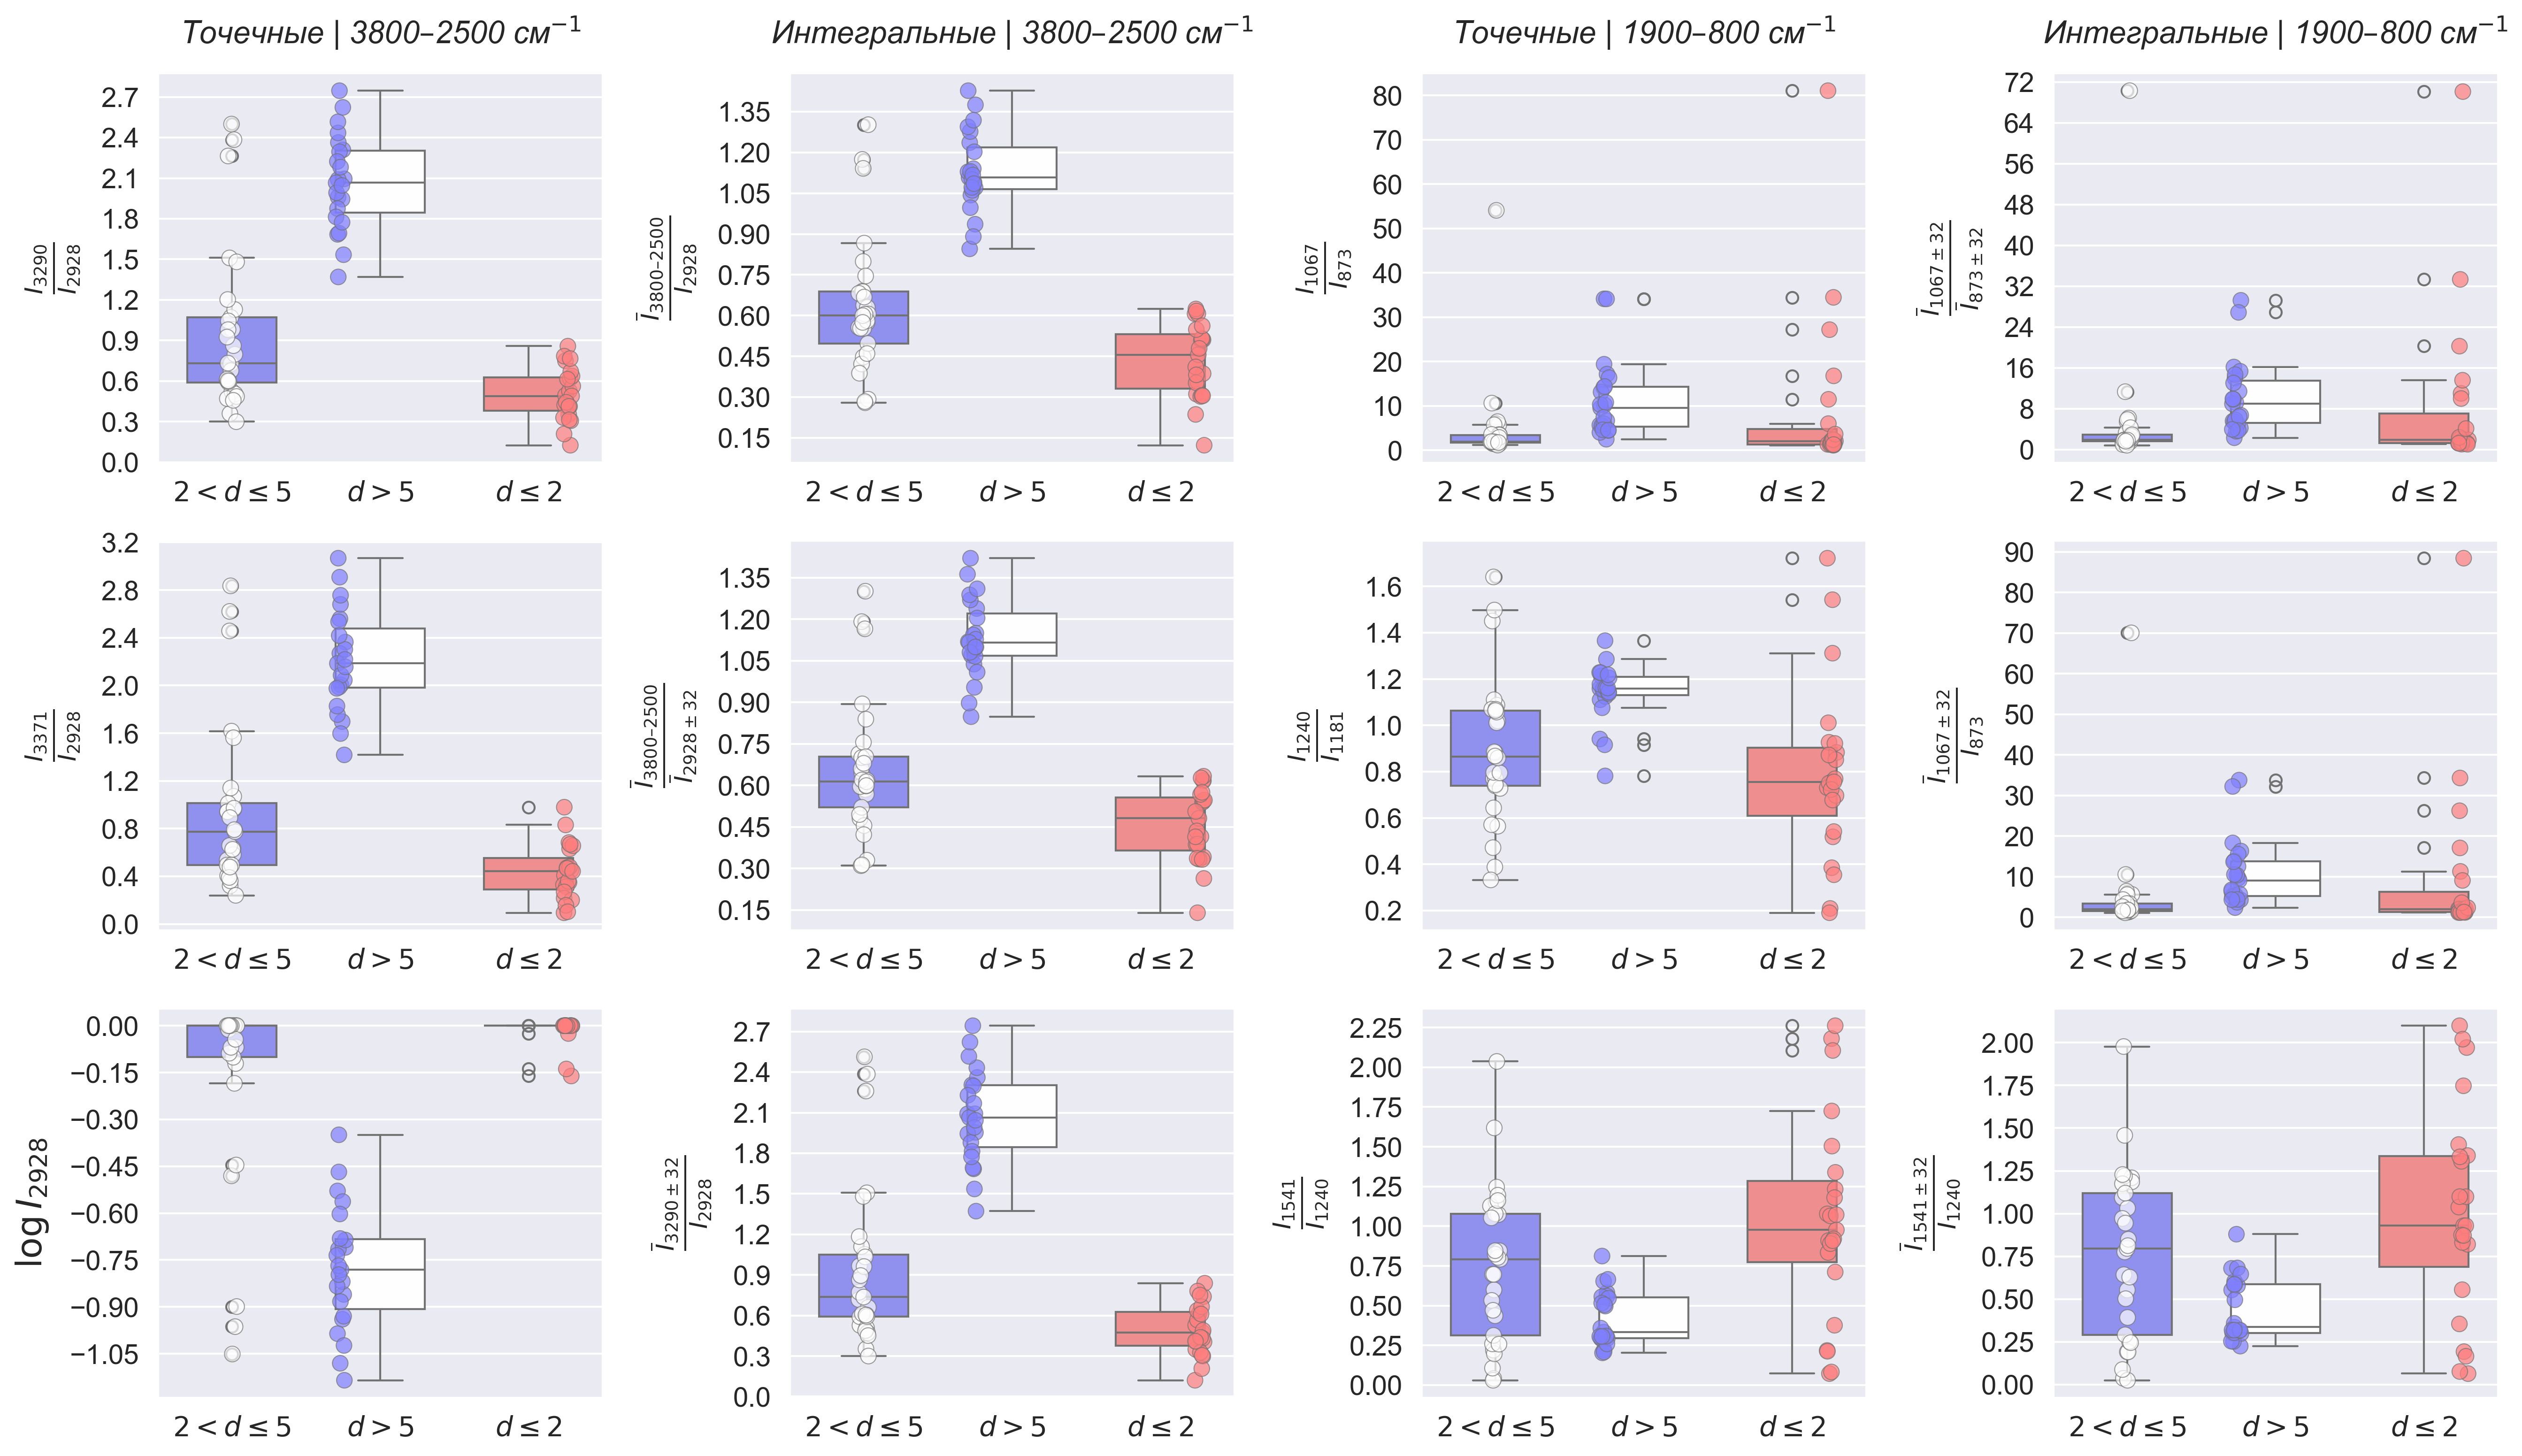

In [32]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.boxplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette='bwr',
            width=PLOT_STYLE['BOX_WIDTH'],
            order=hue_order,
            ax=ax
        )

        sns.stripplot(
            data=df_vis,
            x='hue',
            y=feature,
            hue='hue',
            palette='bwr',
            alpha=PLOT_STYLE['STRIP_ALPHA'],
            size=PLOT_STYLE['STRIP_SIZE'],
            linewidth=PLOT_STYLE['STRIP_LINEWIDTH'],
            dodge=PLOT_STYLE['STRIP_DODGE'],
            ax=ax,
            legend=False
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title, fontsize=PLOT_STYLE['TITLE_FONT_SIZE'], fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'], pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(feature, fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])

        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/boxplot_engineered_features.png', dpi=600)

plt.show()

#### Violin plot

In [33]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 16,
    'TITLE_FONTSTYLE': 'italic',
    'X_LABEL_FONT_SIZE': 16,
    'Y_LABEL_FONT_SIZE': 18,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 14,
    'X_LABELPAD': 10,
    'Y_LABELPAD': 10,
    'X_NBINS': 10,
    'VIOLIN_INNER': 'box',     # 'box', 'quartile', 'point', None
    'VIOLIN_CUT': 0,
    'VIOLIN_LINEWIDTH': 1,
    'PALETTE': 'bwr',
}


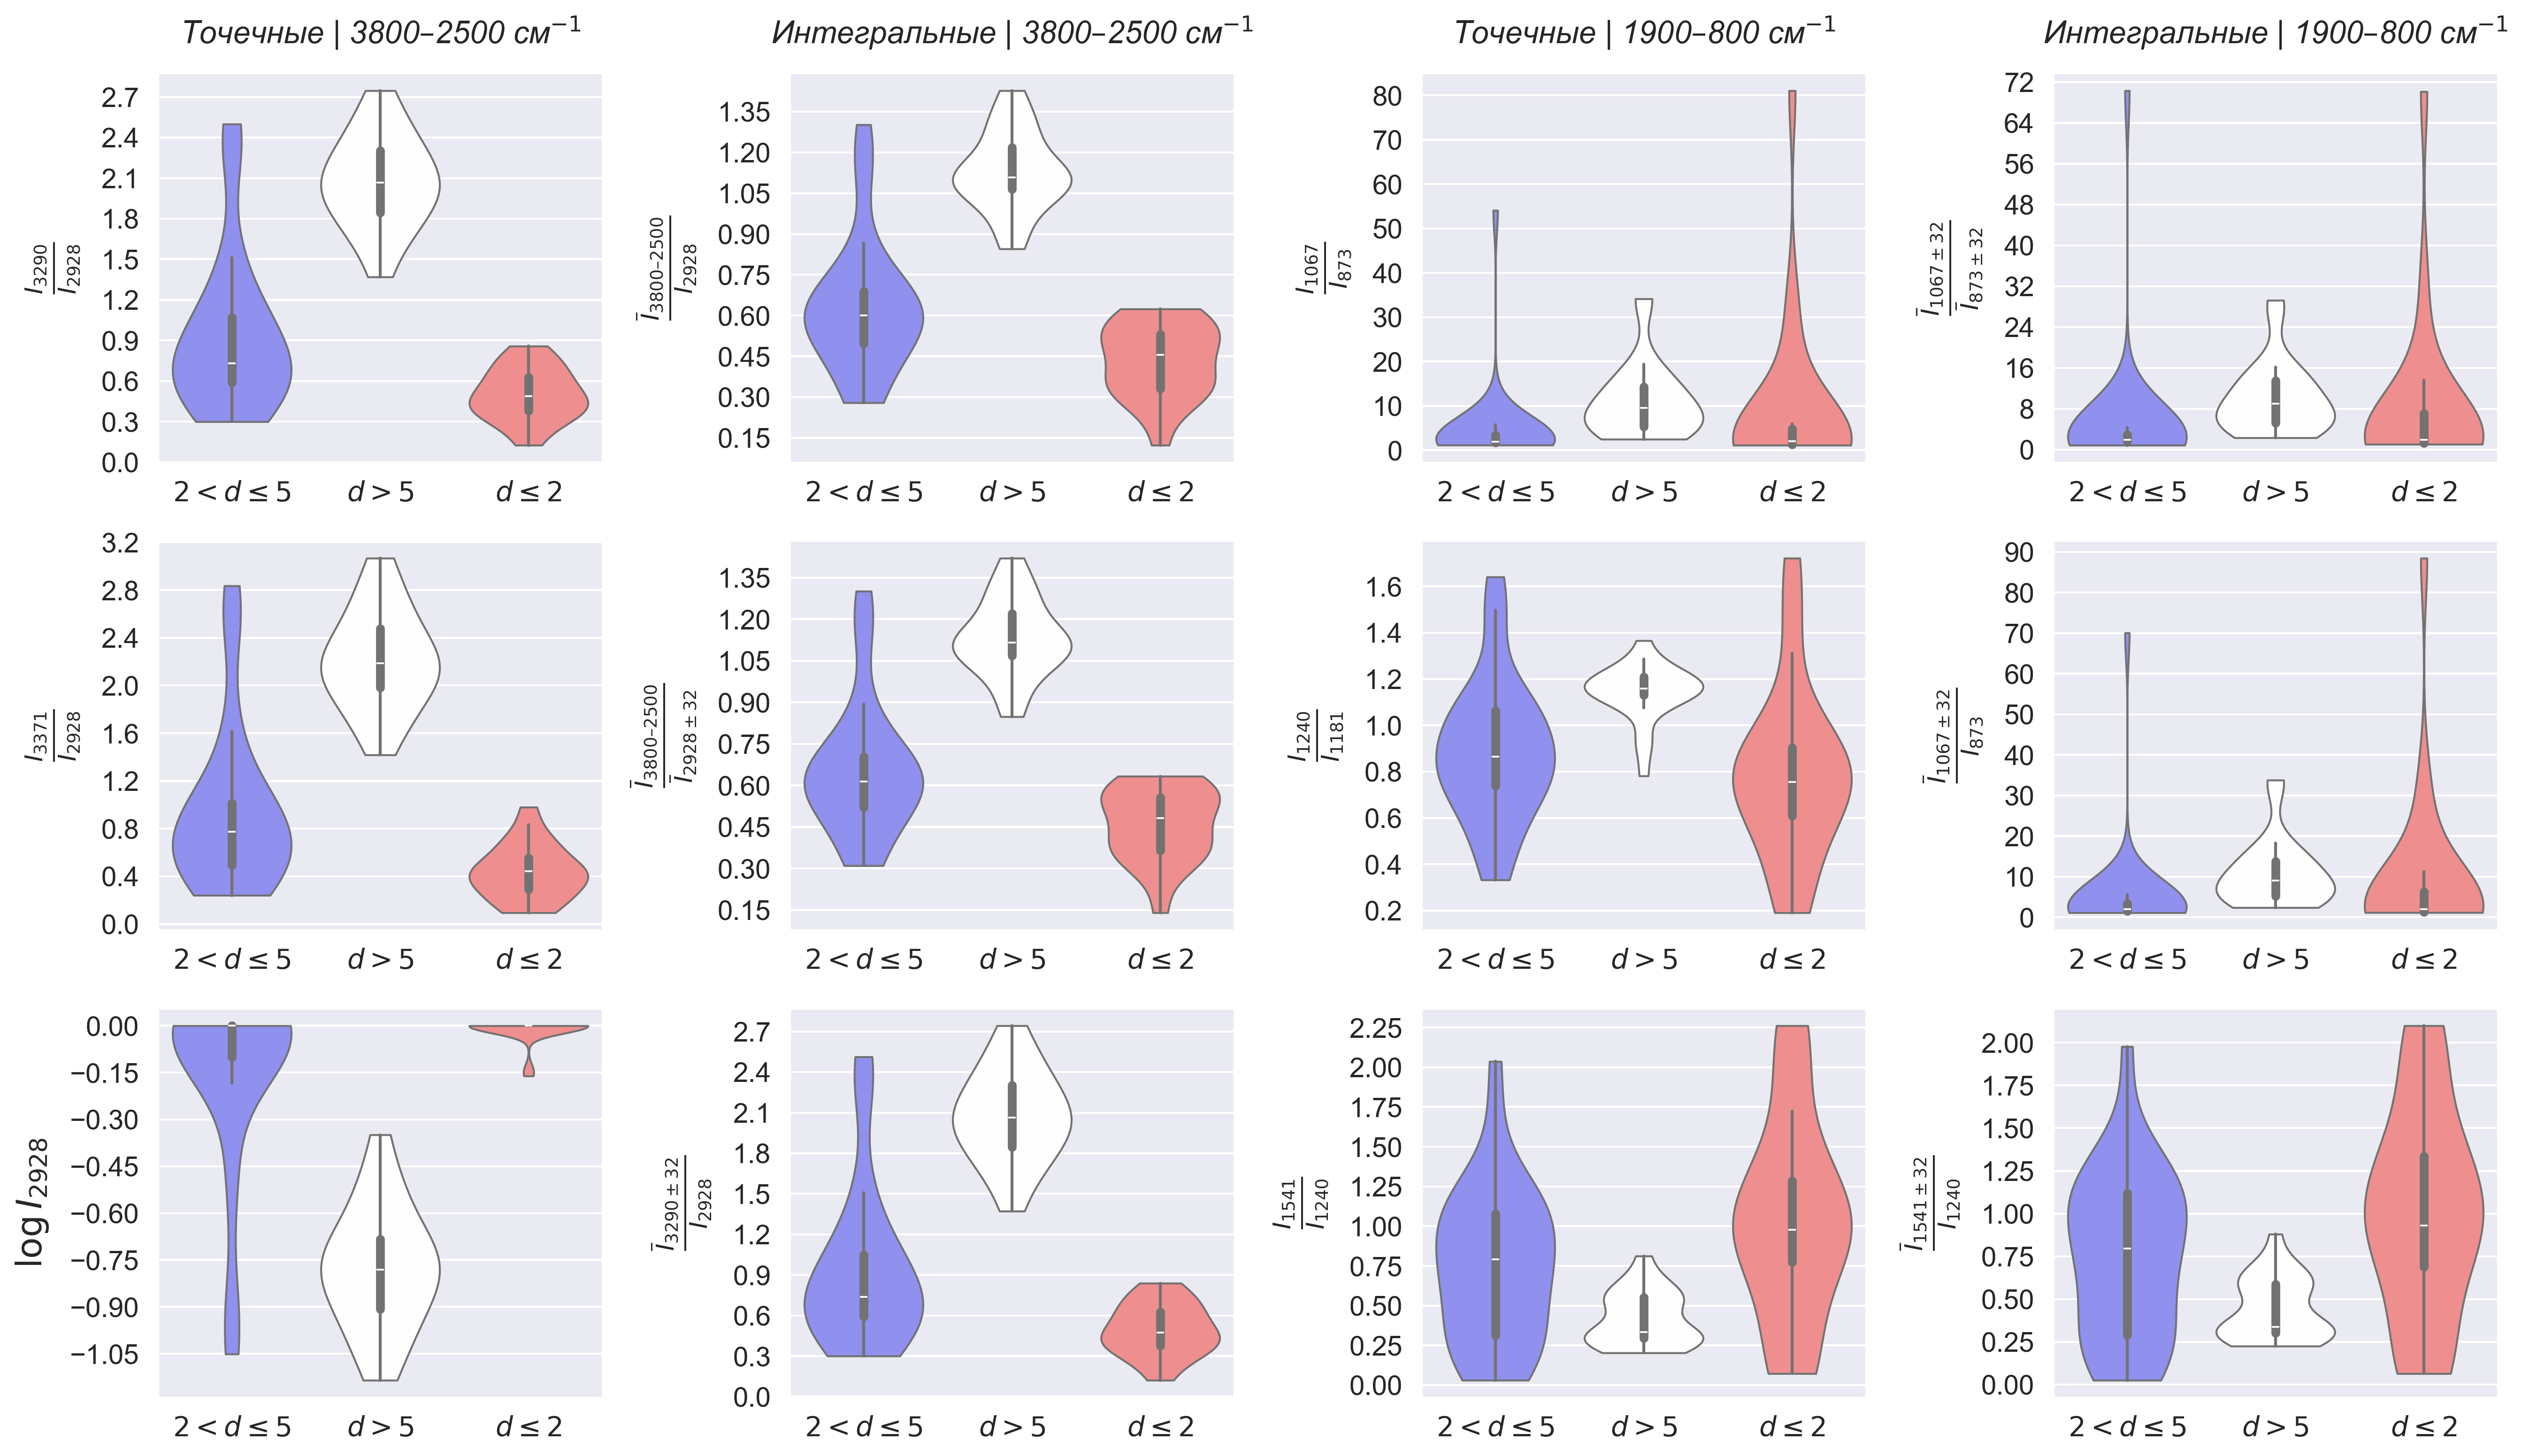

In [34]:
ncols = len(grouped_features)
nrows = 3

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 3.5), dpi=300)
axes = axes.T.flatten()

for col_idx, (feature_type, features) in enumerate(grouped_features.items()):
    for row_idx, feature in enumerate(features):
        ax = axes[col_idx * 3 + row_idx]

        sns.violinplot(
            data=df_vis,
            x='hue',
            y=feature,
            palette=PLOT_STYLE['PALETTE'],
            cut=PLOT_STYLE['VIOLIN_CUT'],
            inner=PLOT_STYLE['VIOLIN_INNER'],
            linewidth=PLOT_STYLE['VIOLIN_LINEWIDTH'],
            order=hue_order,
            ax=ax
        )

        if row_idx == 0:
            key = '_'.join(feature_type.split('_')[2:])
            title = f'{TITLE_MAP.get(key, feature_type)}'
            ax.set_title(title,
                         fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
                         fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
                         pad=15)

        ax.set_xlabel('')
        ax.set_ylabel(
            feature,
            fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'],
            labelpad=PLOT_STYLE['Y_LABELPAD']
        )

        ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
        ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

plt.tight_layout()

plt.savefig(f'{path_to_save}/violinplot_engineered_features.png', dpi=600)

plt.show()